<a href="https://colab.research.google.com/github/thdnjs0730/2024-1-my-BDA/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D%EA%B3%BC%EC%A0%9C_03%EC%A1%B0_20231596_%EC%B5%9C%EC%86%8C%EC%9B%90_20231596_%EC%B5%9C%EC%86%8C%EC%9B%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 청소년 상담 접근성 향상
---

## 주제 선정 이유
1.   저출생과 고령화의 고속 진행
2.   청소년 우울감의 확대

## 문제 해결 목표

*   청소년은 미래의 사회, 경제적 리더가 될 집단
*   미래 사회의 중심, 청소년들의 정신 건강의 중요성
> **청소년 정신의 안정화는 중요한 일**

## 사용 데이터
###1. 청소년 우울감 경험률.csv
- 230530_보도자료_ 2023년 청소년 통계 발표_최종배포본.pdf
- 여성가족부 제공

###2. 유동인구.csv
- 230530_보도자료_ 2023년 청소년 통계 발표_최종배포본.pdf
- 서울교통공사 제공

###3. 거주인구.csv
- 202403_202403_주민등록 인구 기타현황(아동청소년청년 인구현황)_ChYouth.csv
- 행정안전부 제공

###4. SIG_Seoul.geojson
- https://github.com/youngwoos/Doit_Python

---
## 파이썬 설치 확인


In [144]:
import sys
sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

In [145]:
import site
site.getsitepackages()

['/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.10/dist-packages']

In [146]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns

print(sys.version)
print(pd.__version__)
print(np.__version__)
print(sns.__version__)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
2.0.3
1.25.2
0.13.1


## 코랩에서 한글 처리

In [147]:
!pip  install koreanize_matplotlib

## 그래프 해상도 설정

In [148]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi':'100'})

In [149]:
# 해상도 선명하게
%config InlineBackend.figure_format = 'retina'

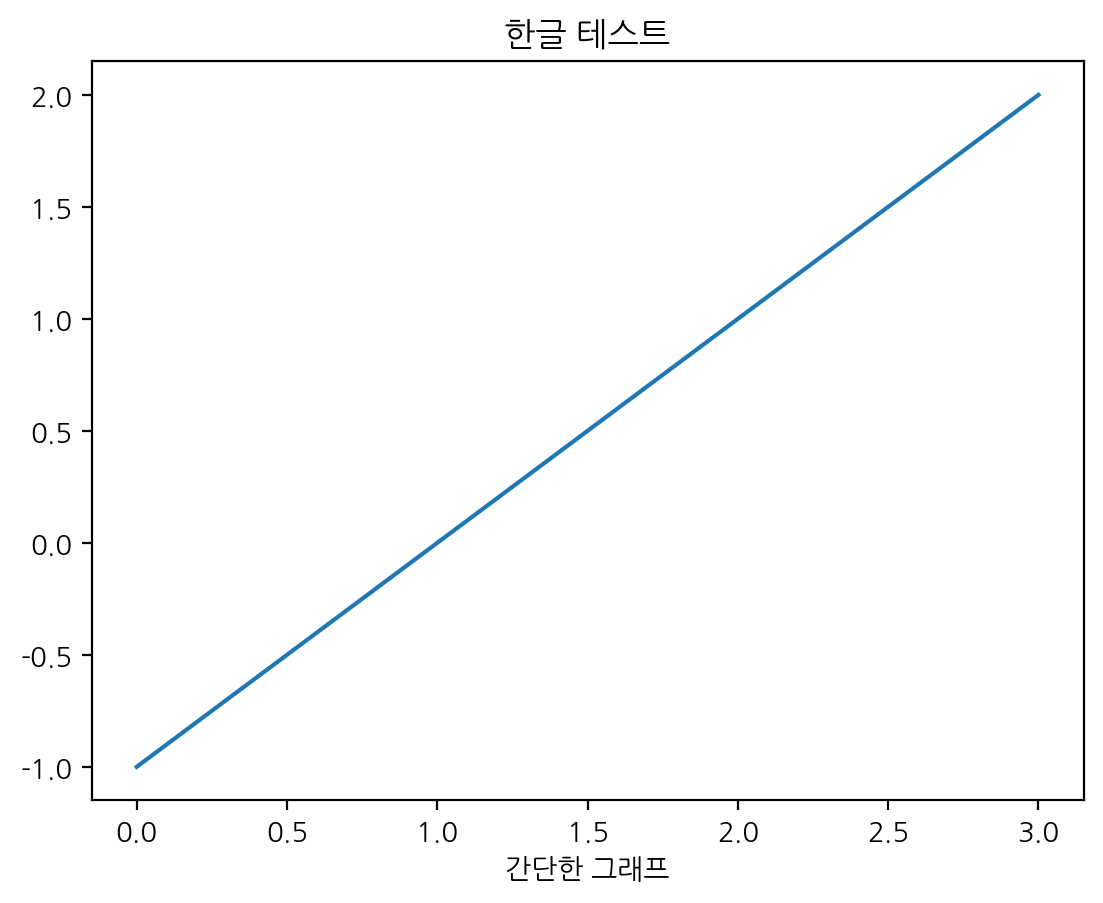

In [150]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.plot([-1, 0, 1, 2])
plt.title('한글 테스트')
plt.xlabel('간단한 그래프')
plt.show()

---
## 1. 청소년 우울감 분석


In [151]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [152]:
# 데이터 로드
dep_pre_df = pd.read_csv('청소년 우울감 경험률.csv')
dep_pre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  12 non-null     int64  
 1   중학생         12 non-null     float64
 2   고등학생        12 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 416.0 bytes


In [153]:
dep_pre_df

,Unnamed: 0,중학생,고등학생
0,2011,30.0,35.5
1,2012,28.2,32.6
2,2013,29.0,32.6
3,2014,24.4,28.8
4,2015,21.2,25.6
5,2016,22.7,27.7
6,2017,23.5,26.4
7,2018,25.2,28.7
8,2019,26.9,29.4
9,2020,22.9,27.4


In [154]:
# 첫 번째 열의 이름을 '연도'로 변경
dep_pre_df.rename(columns={dep_pre_df.columns[0]: '연도'}, inplace=True)

# 연도별 우울감 경험률 변화율 계산
dep_pre_df['중학생 변화율'] = dep_pre_df['중학생'].pct_change() * 100
dep_pre_df['고등학생 변화율'] = dep_pre_df['고등학생'].pct_change() * 100

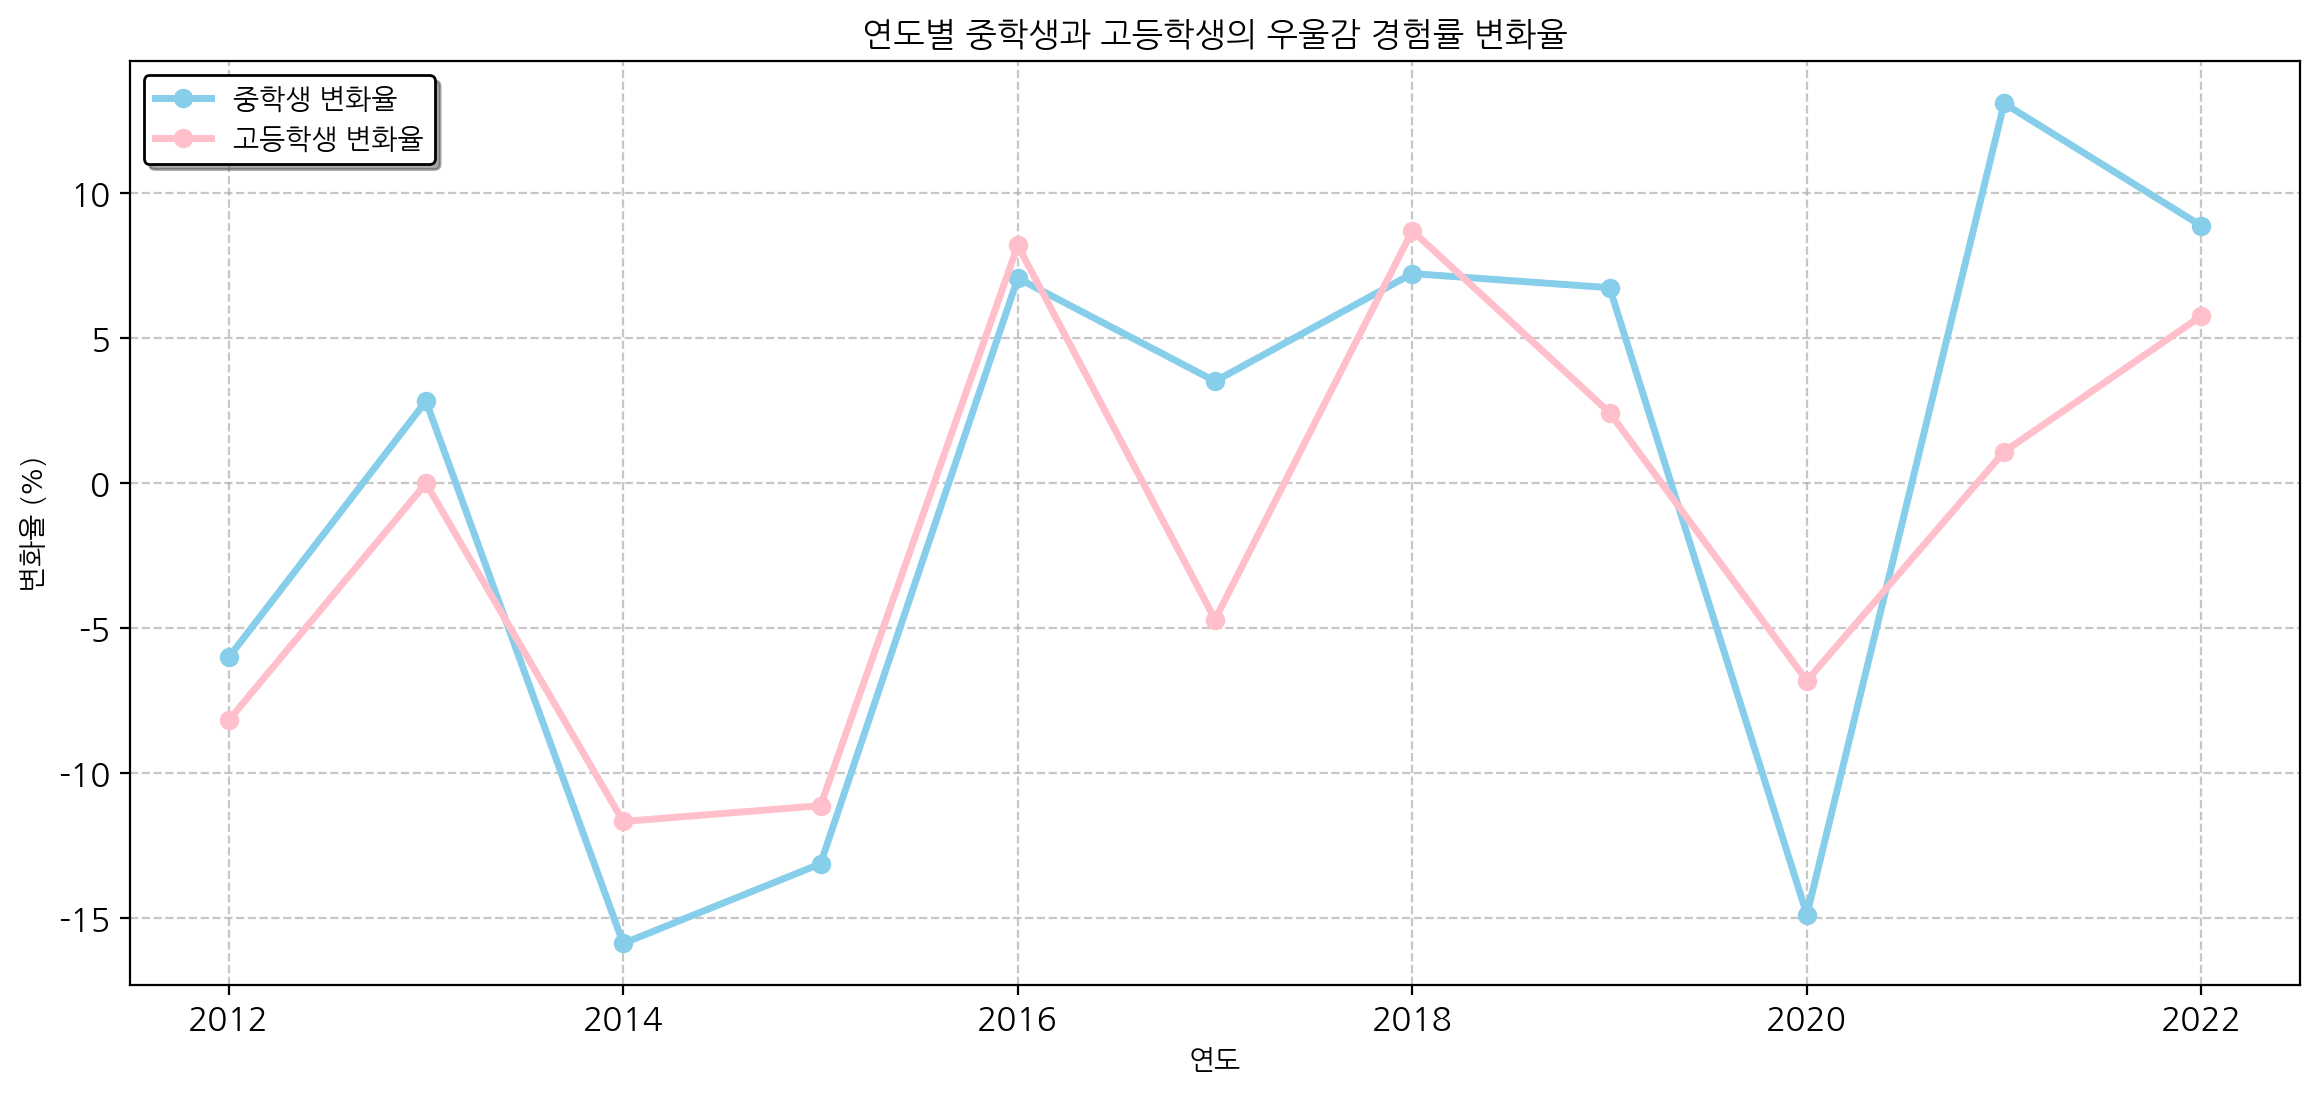

In [155]:
# plot 차트 시각화
plt.figure(figsize=(14, 6))
plt.plot(dep_pre_df['연도'], dep_pre_df['중학생 변화율'], marker='o', label='중학생 변화율', color='skyblue', linewidth=2.5)
plt.plot(dep_pre_df['연도'], dep_pre_df['고등학생 변화율'], marker='o', label='고등학생 변화율', color='pink', linewidth=2.5)
plt.xlabel('연도')
plt.ylabel('변화율 (%)')
plt.title('연도별 중학생과 고등학생의 우울감 경험률 변화율')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(frameon=True, shadow=True, facecolor='white', edgecolor='black')
plt.show()

In [156]:
# 중학생과 고등학생의 우울감 경험률 평균
dep_pre_df['평균'] = (dep_pre_df['중학생'] + dep_pre_df['고등학생'])/2

# 입력 변수(X)와 목표 변수(y) 설정
X = dep_pre_df[['연도']]
y = dep_pre_df['평균']

In [157]:
# SVR 모델 생성 및 학습
svr_model = SVR(kernel='rbf', C=11)  # 가우시안 RBF 커널 사용
svr_model.fit(X, y)

SVR(C=11)

In [158]:
# 2011년부터 2025년까지 예측
X_future = np.arange(2011, 2026).reshape(-1, 1)
y_pred = svr_model.predict(X_future)

# 2023년부터 2025년까지의 예측값 출력
future_predictions = {year: pred for year, pred in zip(range(2023, 2026), y_pred[-3:])}
for year, pred in future_predictions.items():
    print(f"{year}년 예측값: {pred:.2f}")

2023년 예측값: 29.55
2024년 예측값: 30.51
2025년 예측값: 30.68


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


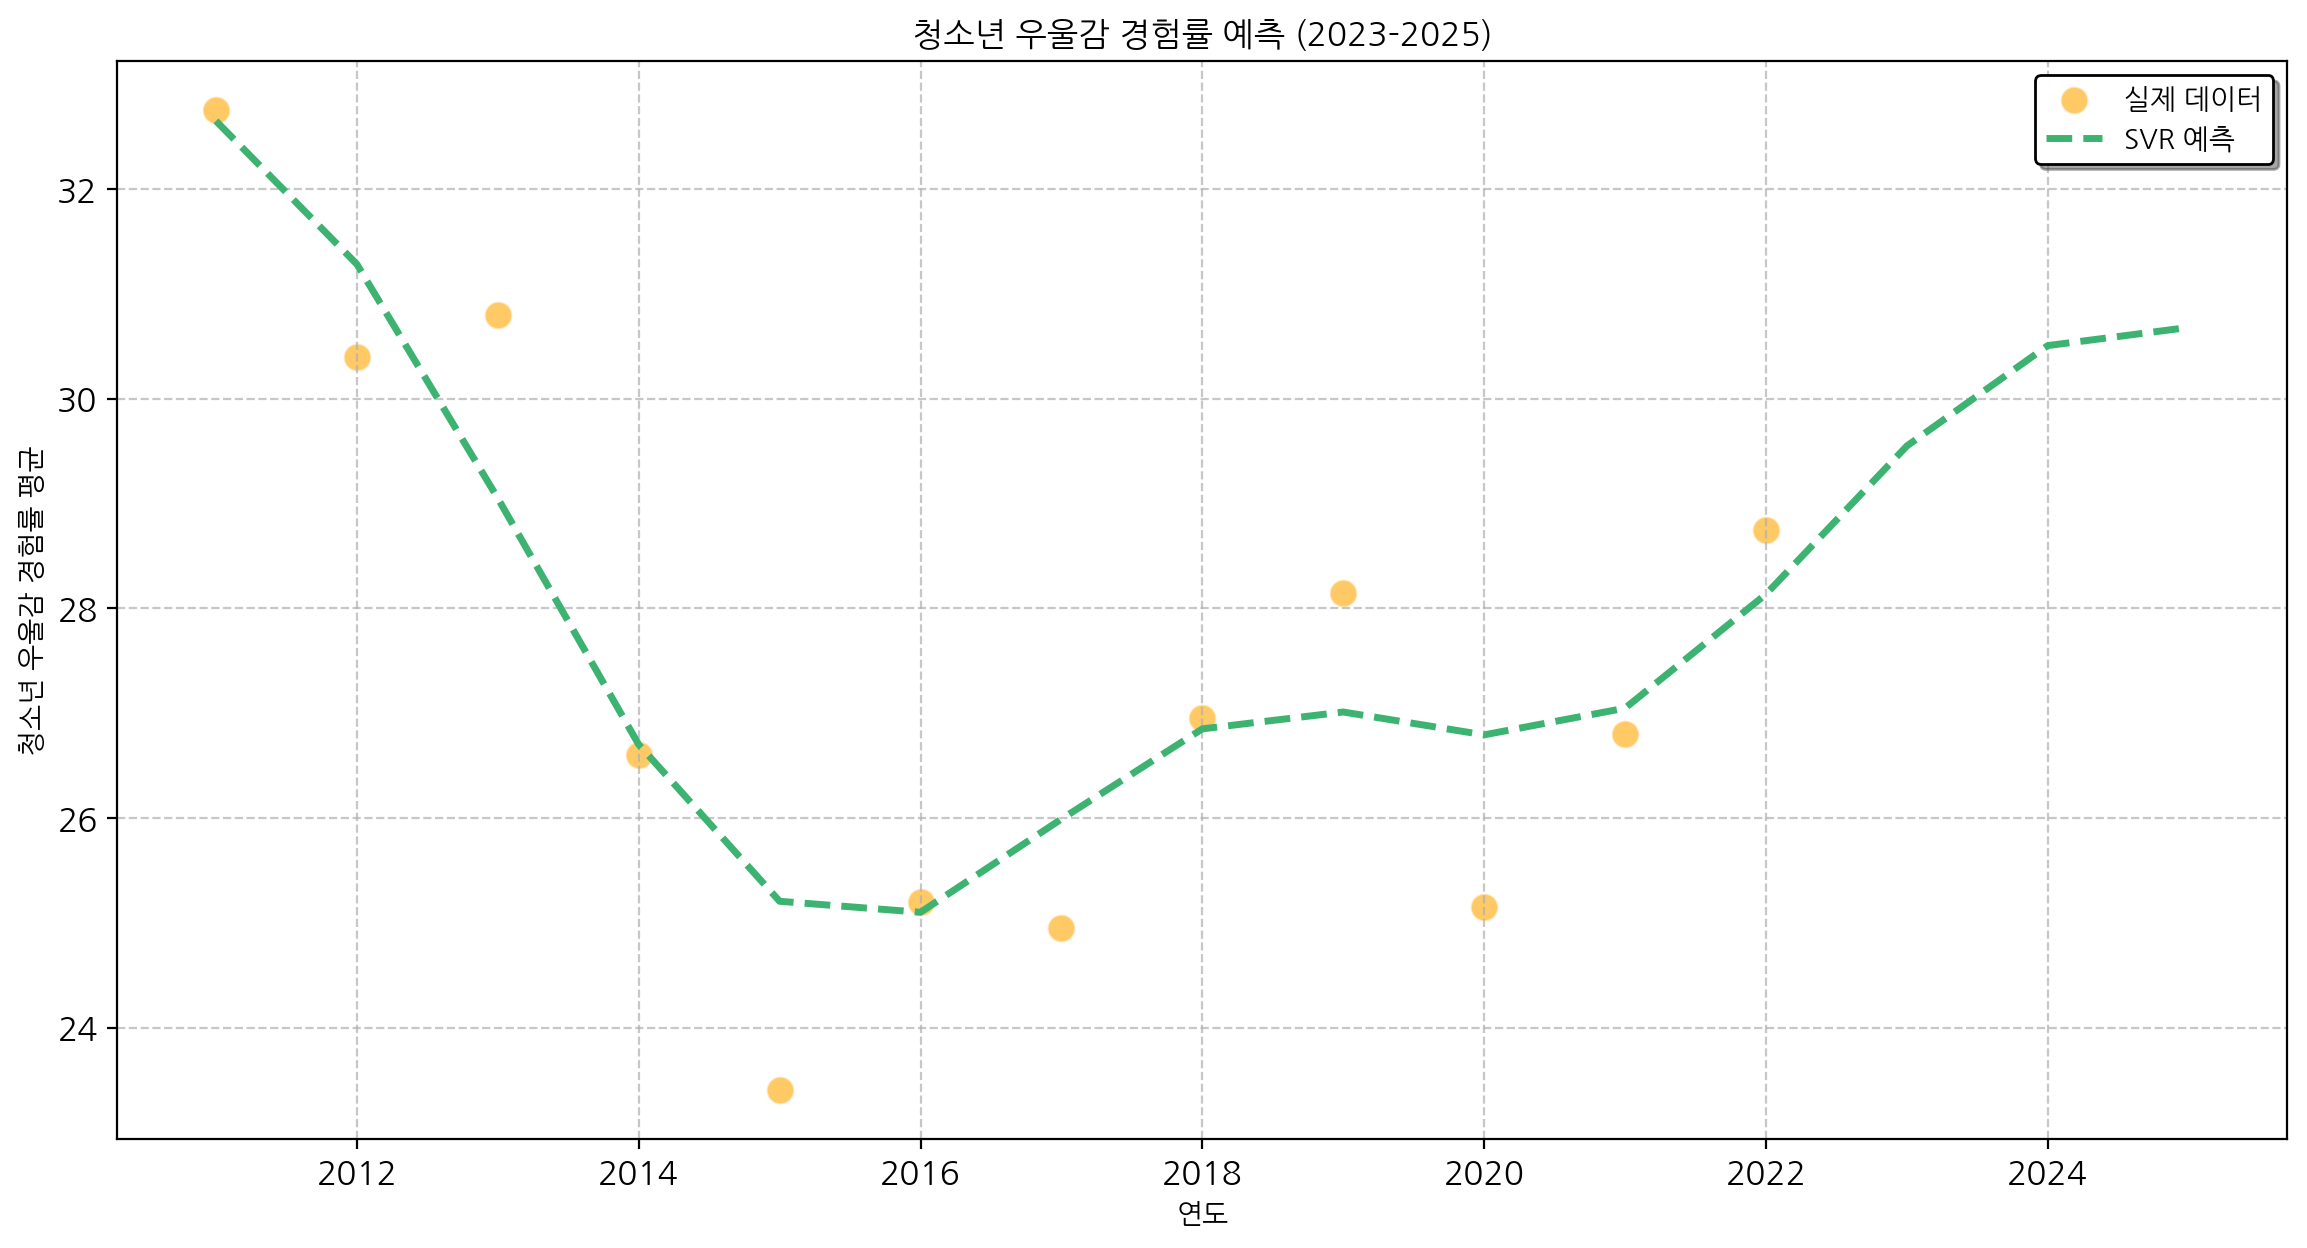

In [159]:
# 산점도, plot 차트 시각화
plt.figure(figsize=(14, 7))
sns.scatterplot(x=dep_pre_df['연도'], y=dep_pre_df['평균'], label='실제 데이터', color='orange', alpha=0.6, s=100)
plt.plot(X_future, y_pred, color='mediumseagreen', linestyle='--', linewidth=2.5, label='SVR 예측')
plt.xlabel('연도')
plt.ylabel('청소년 우울감 경험률 평균')
plt.title('청소년 우울감 경험률 예측 (2023-2025)')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(frameon=True, shadow=True, facecolor='white', edgecolor='black')
plt.show()

### 분석 결과

1. 전반적인 우울감 변화: 감소하는 시기도 분명히 존재하지만, 최근 다시 높아지는 추세
2. 고등학생의 우울감 경험률 높음: 대부분의 연도에서 고등학생의 우울감이 중학생보다 높은 결과를 보임
3. 우울감 상승 예측


## 2. 청소년 이동 지역 분석

In [214]:
# 데이터 로드
move_df = pd.read_csv("이동인구.csv", encoding='cp949')
move_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817644 entries, 0 to 817643
Data columns (total 27 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   연번        817644 non-null  int64 
 1   수송일자      817644 non-null  object
 2   호선명       817644 non-null  int64 
 3   역번호       817644 non-null  int64 
 4   역명        817644 non-null  object
 5   승하차구분     817644 non-null  object
 6   승객유형      817644 non-null  object
 7   06시간대이전   817644 non-null  int64 
 8   06-07시간대  817644 non-null  int64 
 9   07-08시간대  817644 non-null  int64 
 10  08-09시간대  817644 non-null  int64 
 11  09-10시간대  817644 non-null  int64 
 12  10-11시간대  817644 non-null  int64 
 13  11-12시간대  817644 non-null  int64 
 14  12-13시간대  817644 non-null  int64 
 15  13-14시간대  817644 non-null  int64 
 16  14-15시간대  817644 non-null  int64 
 17  15-16시간대  817644 non-null  int64 
 18  16-17시간대  817644 non-null  int64 
 19  17-18시간대  817644 non-null  int64 
 20  18-19시간대  817644 non-null 

In [215]:
move_df

,연번,수송일자,호선명,역번호,역명,승하차구분,승객유형,06시간대이전,06-07시간대,07-08시간대,...,15-16시간대,16-17시간대,17-18시간대,18-19시간대,19-20시간대,20-21시간대,21-22시간대,22-23시간대,23-24시간대,24시간대이후
0,1,2023-07-01,1,150,서울역,승차,일반,192,192,409,...,2989,3514,3409,2686,2347,1872,2209,1885,691,7
1,2,2023-07-01,1,150,서울역,승차,어린이,0,1,3,...,33,32,30,30,30,16,11,8,4,0
2,3,2023-07-01,1,150,서울역,승차,중고생,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,4,2023-07-01,1,150,서울역,승차,청소년,0,3,12,...,47,52,54,46,47,47,54,34,13,0
4,5,2023-07-01,1,150,서울역,승차,우대권,88,105,212,...,580,608,560,381,265,277,197,121,31,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817639,817642,2023-12-31,8,2828,남위례,하차,일반,7,37,42,...,149,193,204,224,187,146,154,151,98,91
817640,817643,2023-12-31,8,2828,남위례,하차,어린이,0,0,0,...,1,2,1,1,7,7,0,2,0,0
817641,817644,2023-12-31,8,2828,남위례,하차,청소년,0,0,1,...,15,20,27,21,16,22,6,16,6,16
817642,817645,2023-12-31,8,2828,남위례,하차,우대권,10,15,24,...,63,55,32,46,42,28,21,17,10,6


In [216]:
# 청소년 승객 필터링
is_teenager = move_df['승객유형'] == '청소년'
teenager = move_df[is_teenager]

In [217]:
# 최대 승차 및 하차 인원과 시간을 저장 리스트 초기화
mx_on = [0] * 20
mx_off = [0] * 20
mx_station = [''] * 20
mx_station_on = [''] * 20
mx_station_off = [''] * 20
mx_time = [0] * 20

In [218]:
# 각 시간대별 최대 승차 및 하차 인원과 역 찾기
for row in teenager.itertuples(index=False):
    for i in range(20):
        temp = row[i + 7]  # 시간대별 승차/하차 인원
        if row[5] == '승차':  # 승차일 경우
            if temp > mx_on[i]:  # 최대 승차 인원을 갱신할 경우
                mx_on[i] = temp
                t = (i + 6) % 24
                if t == 0:
                    t = 24
                mx_time[i] = t  # 시간대 저장
                mx_station_on[i] = row[4]  # 역 이름 저장
        elif row[5] == '하차':  # 하차일 경우
            if temp > mx_off[i]:  # 최대 하차 인원을 갱신할 경우
                mx_off[i] = temp
                t = (i + 6) % 24
                if t == 0:
                    t = 24
                mx_time[i] = t  # 시간대 저장
                mx_station_off[i] = row[4]  # 역 이름 저장

        # 승차 및 하차 역 정보를 통합하여 저장
        mx_station[i] = f'승차: {mx_station_on[i]}\n하차: {mx_station_off[i]} ({mx_time[i]}시)'

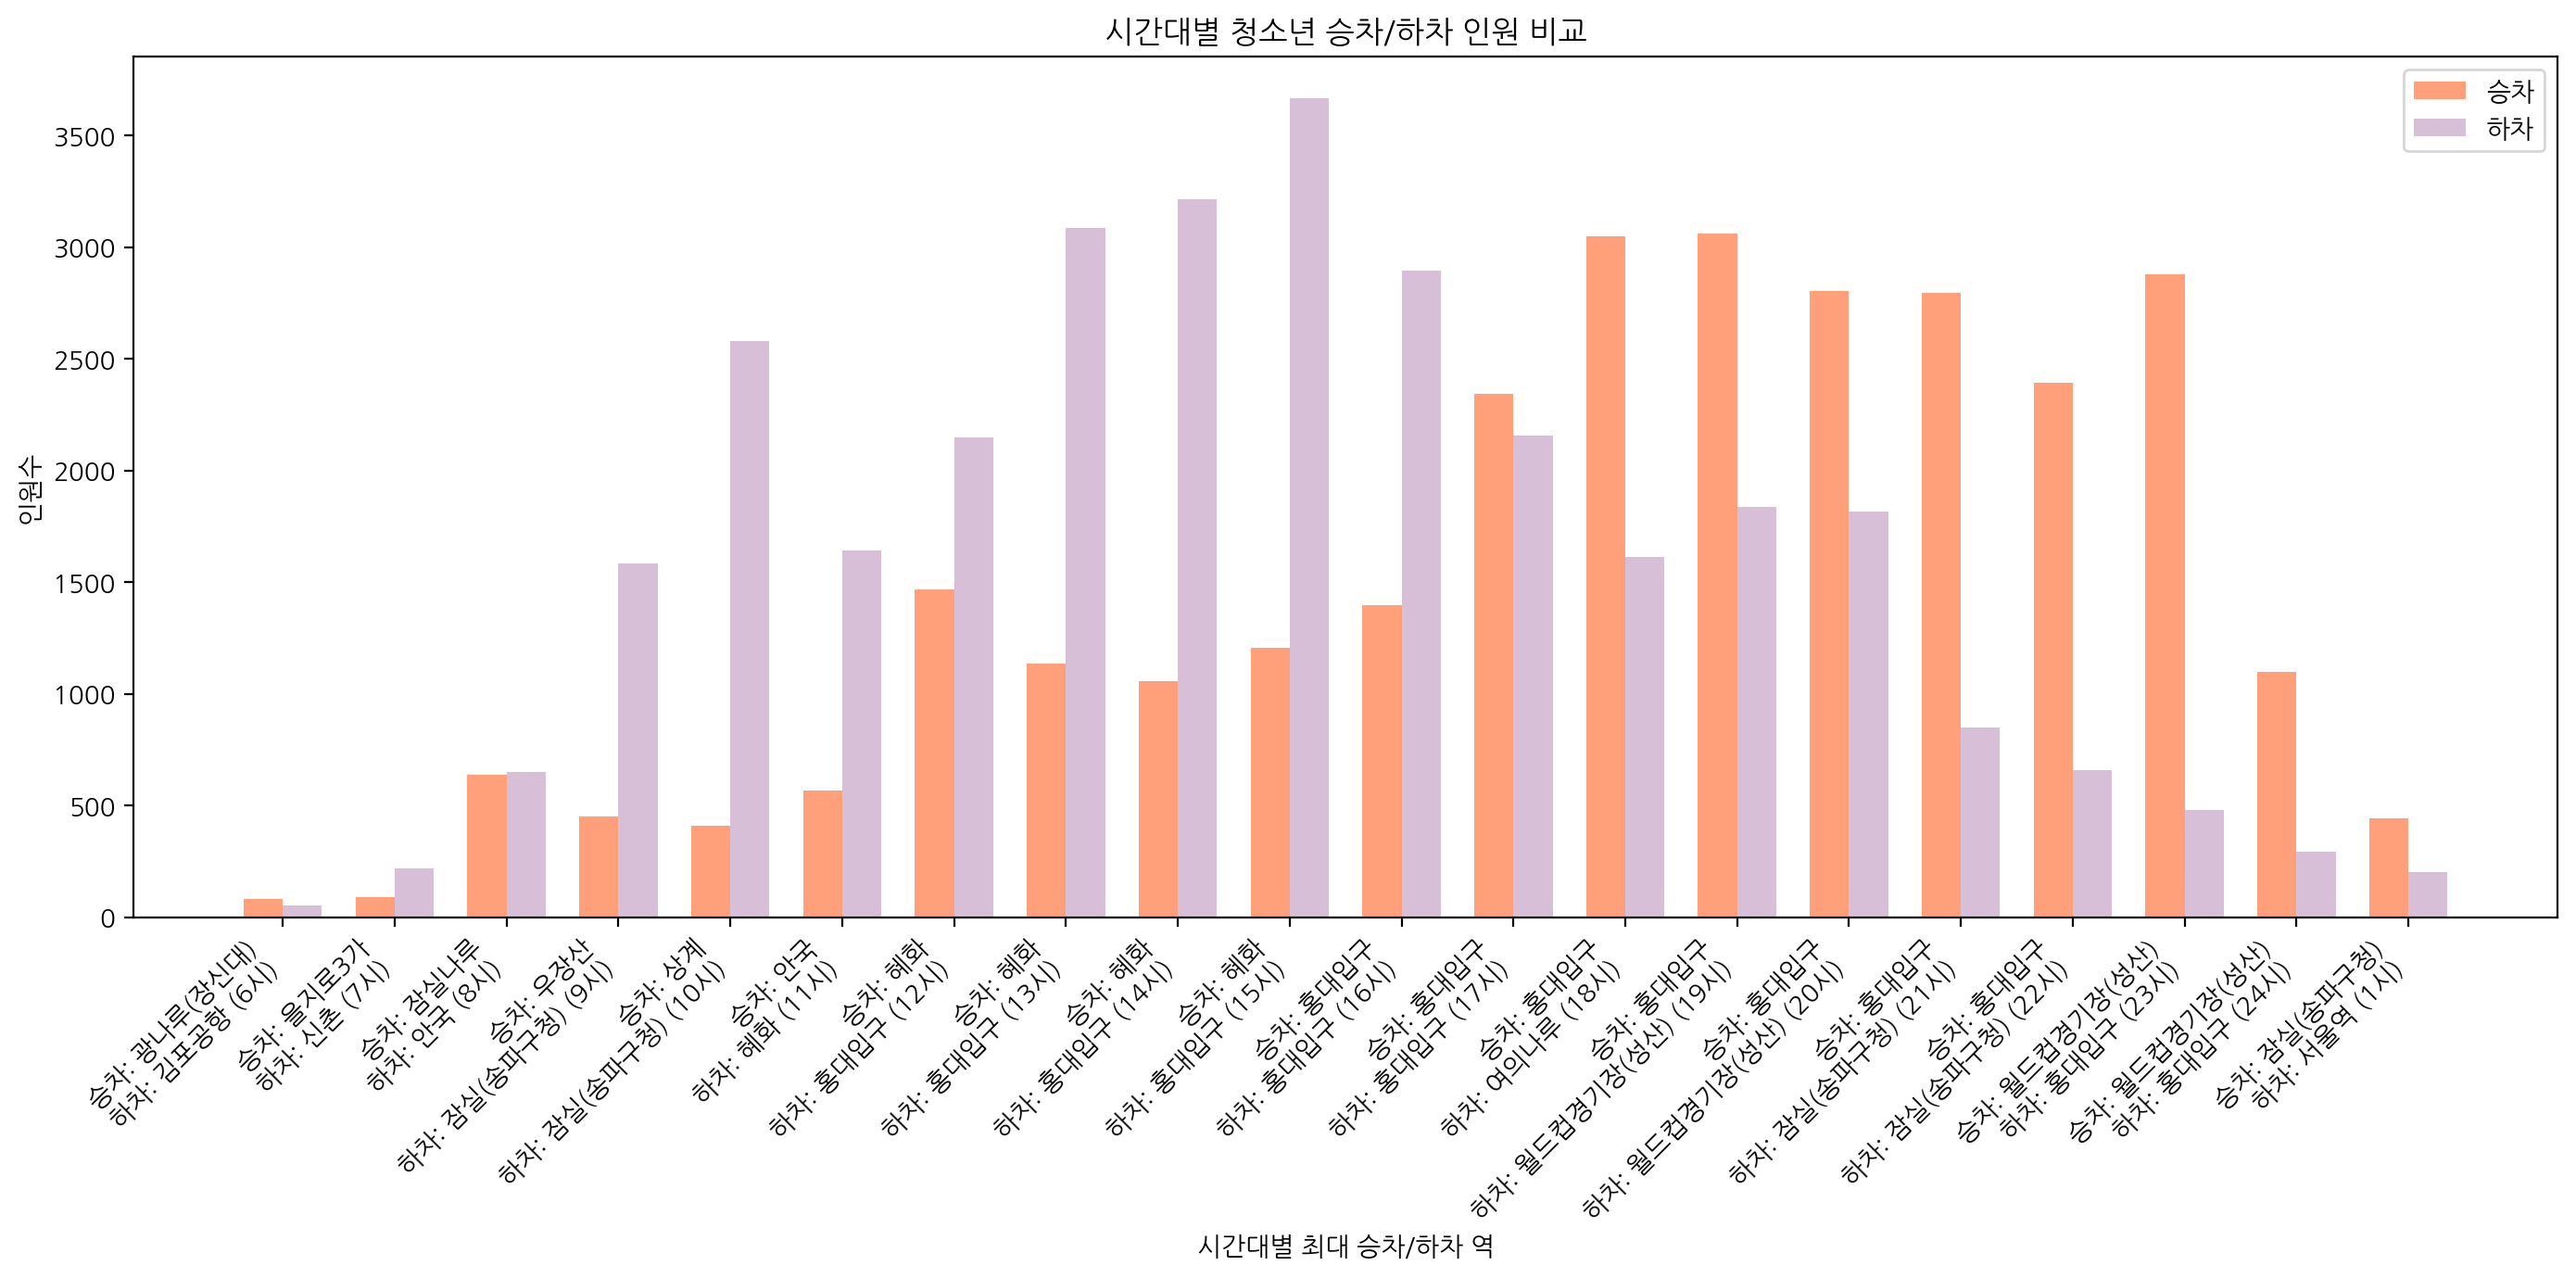

In [219]:
fig, axx = plt.subplots(figsize=(14, 7))
bar_width = 0.35
index = np.arange(20)

# 바 차트 시각화
plt.bar(index, mx_on, bar_width, label='승차', color='lightsalmon')
plt.bar(index + bar_width, mx_off, bar_width, label='하차', color='thistle')
plt.xlabel('시간대별 최대 승차/하차 역')
plt.ylabel('인원수')
plt.title('시간대별 청소년 승차/하차 인원 비교')
plt.xticks(index + bar_width / 2, mx_station, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [220]:
# '승하차구분'이 '승차'이고 '승객유형'이 '청소년'인 데이터만 필터링
boarding_df = move_df[(move_df['승하차구분'] == '승차') & (move_df['승객유형'] == '청소년')]

# '승하차구분'이 '하차'이고 '승객유형'이 '청소년'인 데이터만 필터링
alighting_df = move_df[(move_df['승하차구분'] == '하차') & (move_df['승객유형'] == '청소년')]

In [229]:
# 시간대 열만 포함한 데이터프레임 생성 (열 인덱스 범위로 선택)
time_columns = boarding_df.columns[7:27]

In [230]:
# 노선별로 그룹화하여 시간대 열의 평균 계산 (승차)
boarding_group = boarding_df.groupby('호선명')[time_columns].mean().reset_index()

# 데이터를 '호선명', '시간대', '평균 청소년 승차 인원' 형태로 변형 (승차)
boarding_melted = pd.melt(boarding_df, id_vars=['호선명'], value_vars=time_columns, var_name='시간대', value_name='평균 청소년 승차 인원')

In [231]:
# 노선별로 그룹화하여 시간대 열의 평균 계산 (하차)
alighting_group = alighting_df.groupby('호선명')[time_columns].mean().reset_index()

# 데이터를 '호선명', '시간대', '평균 청소년 하차 인원' 형태로 변형 (하차)
alighting_melted = pd.melt(alighting_group, id_vars=['호선명'], value_vars=time_columns, var_name='시간대', value_name='평균 청소년 하차 인원')

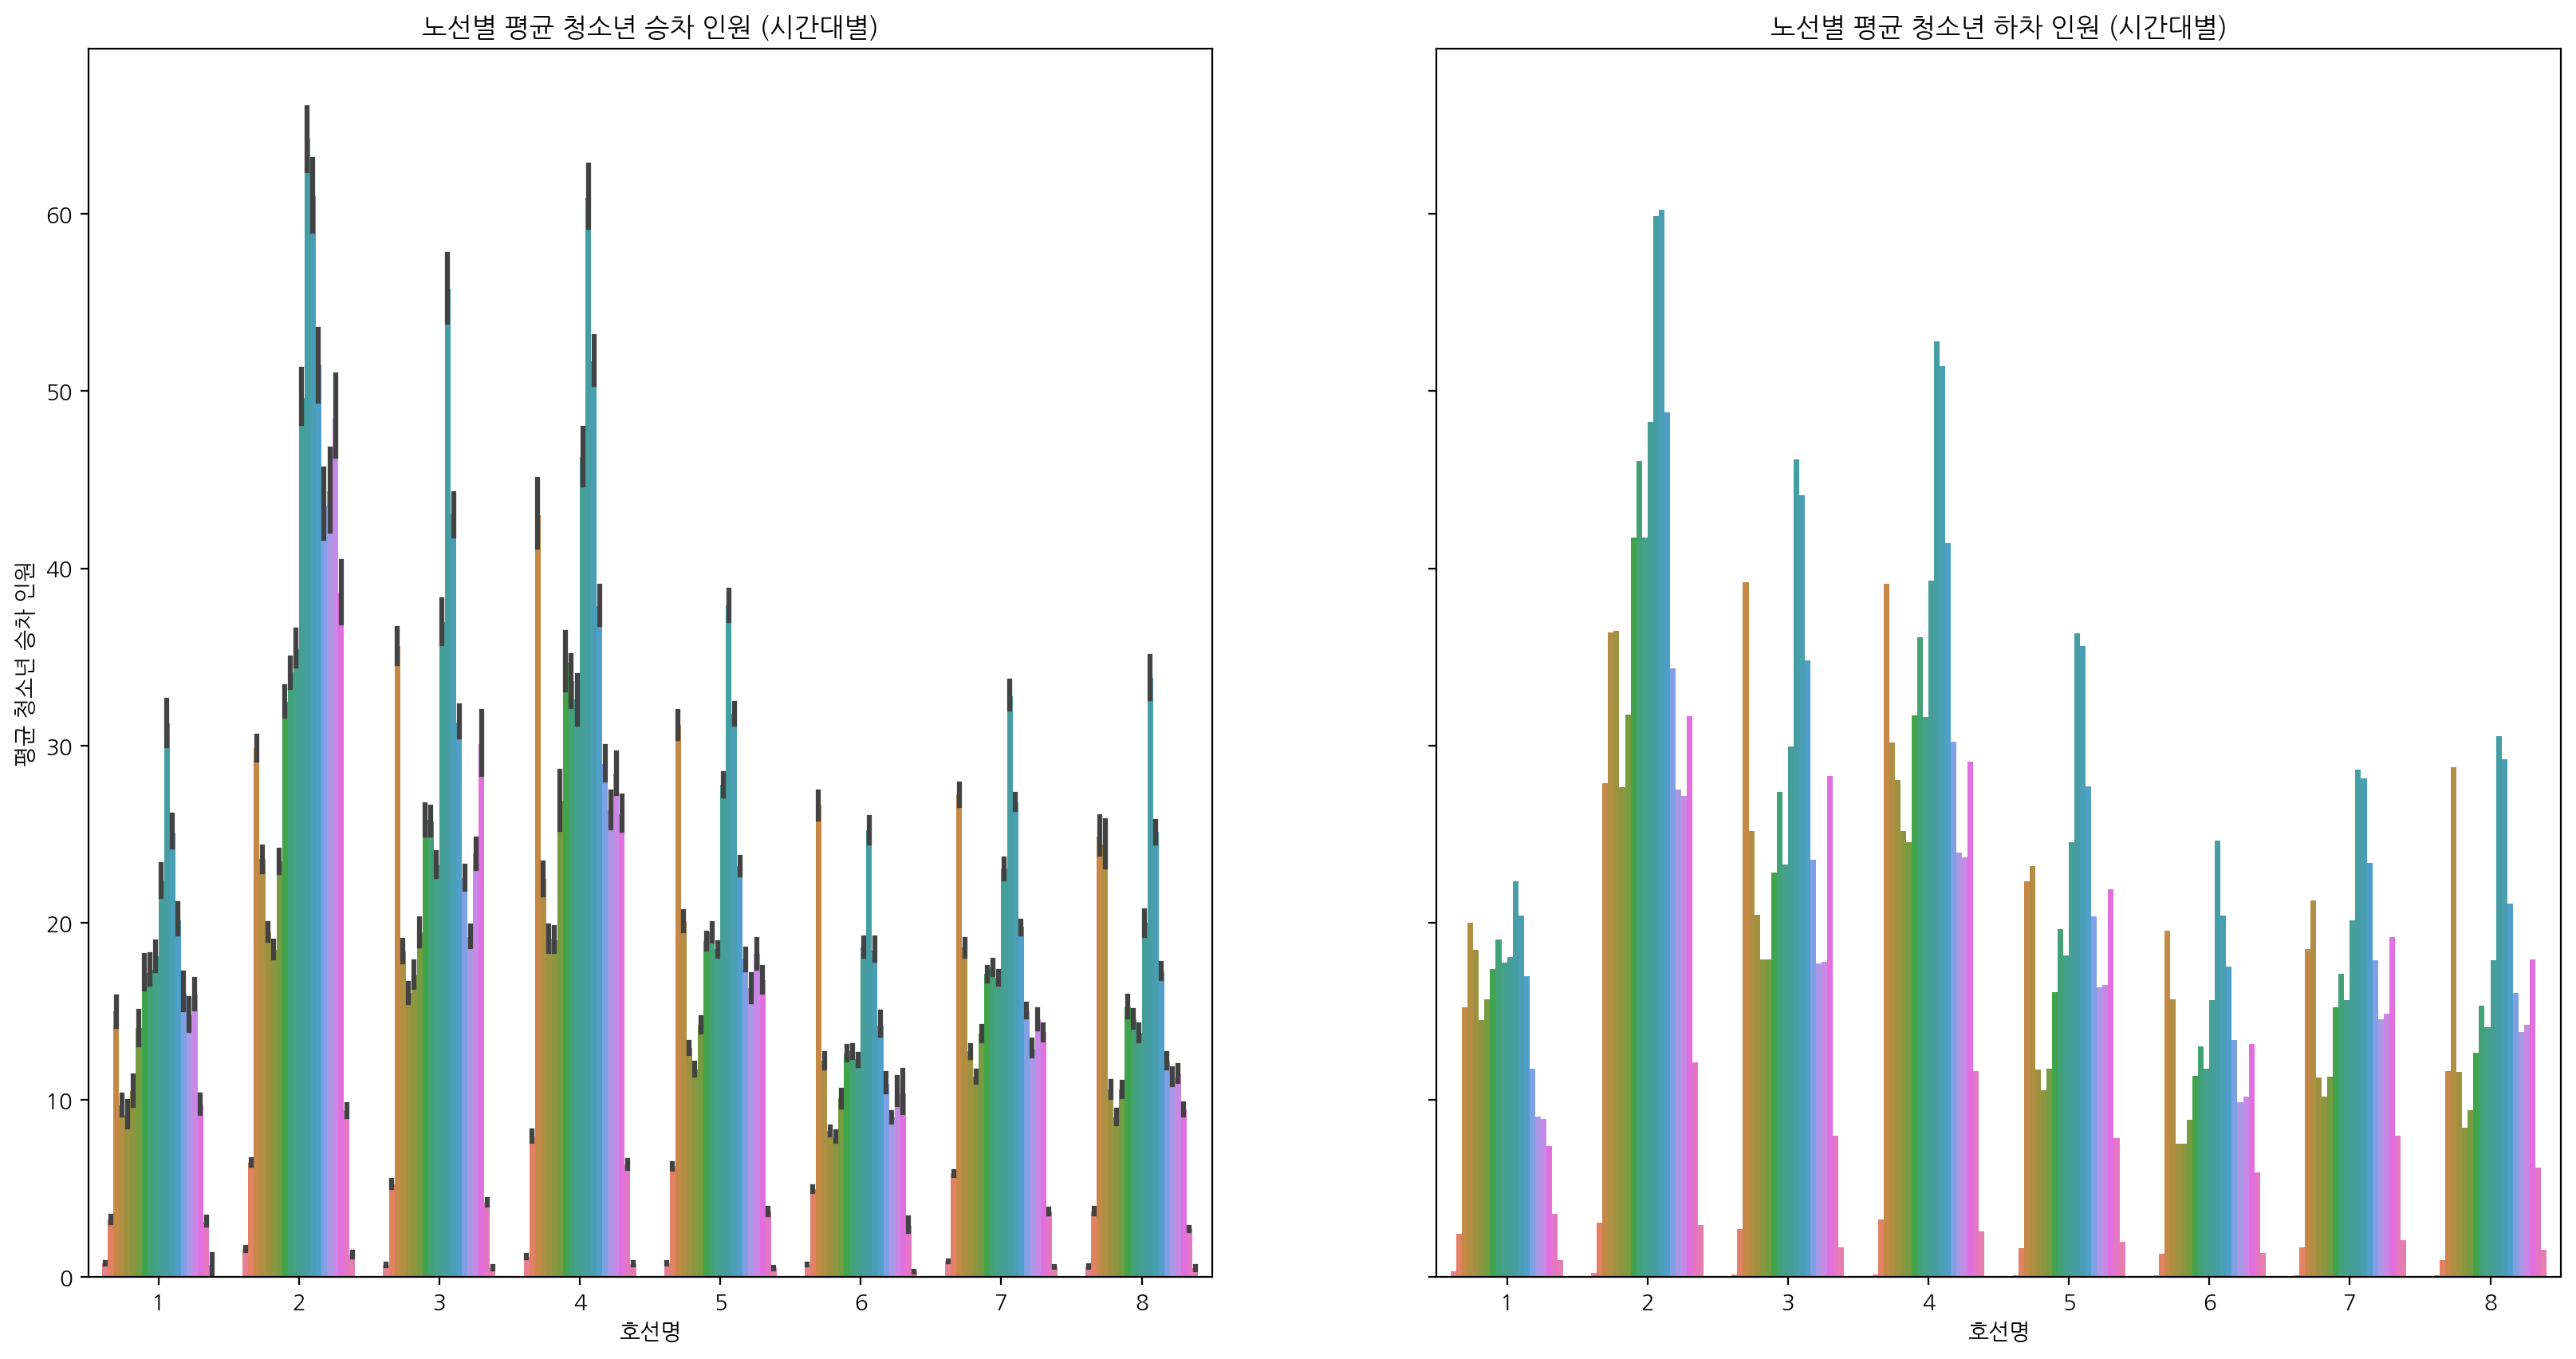

In [232]:
# 그래프 그리기
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

sns.barplot(ax=axes[0], x='호선명', y='평균 청소년 승차 인원', hue='시간대', data=boarding_melted)
axes[0].set_title('노선별 평균 청소년 승차 인원 (시간대별)')
axes[0].legend([],[], frameon=False)  # 범례 제거

sns.barplot(ax=axes[1], x='호선명', y='평균 청소년 하차 인원', hue='시간대', data=alighting_melted)
axes[1].set_title('노선별 평균 청소년 하차 인원 (시간대별)')
axes[1].legend([],[], frameon=False)  # 범례 제거

In [225]:
# 청소년 데이터에서 요일 정보 추출
teenager['수송일자'] = pd.to_datetime(teenager['수송일자'])
teenager['요일'] = teenager['수송일자'].dt.dayofweek

<ipython-input-225-6ea2cce3cdf5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teenager['수송일자'] = pd.to_datetime(teenager['수송일자'])
<ipython-input-225-6ea2cce3cdf5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teenager['요일'] = teenager['수송일자'].dt.dayofweek


In [226]:
# 주중과 주말로 나누기
data_weekday = teenager[teenager['요일'] <= 4]
data_weekend = teenager[teenager['요일'] >= 5]

In [227]:
# 주중과 주말의 평균 승객 수 계산
mean_weekday = data_weekday[time_columns].mean()
mean_weekend = data_weekend[time_columns].mean()

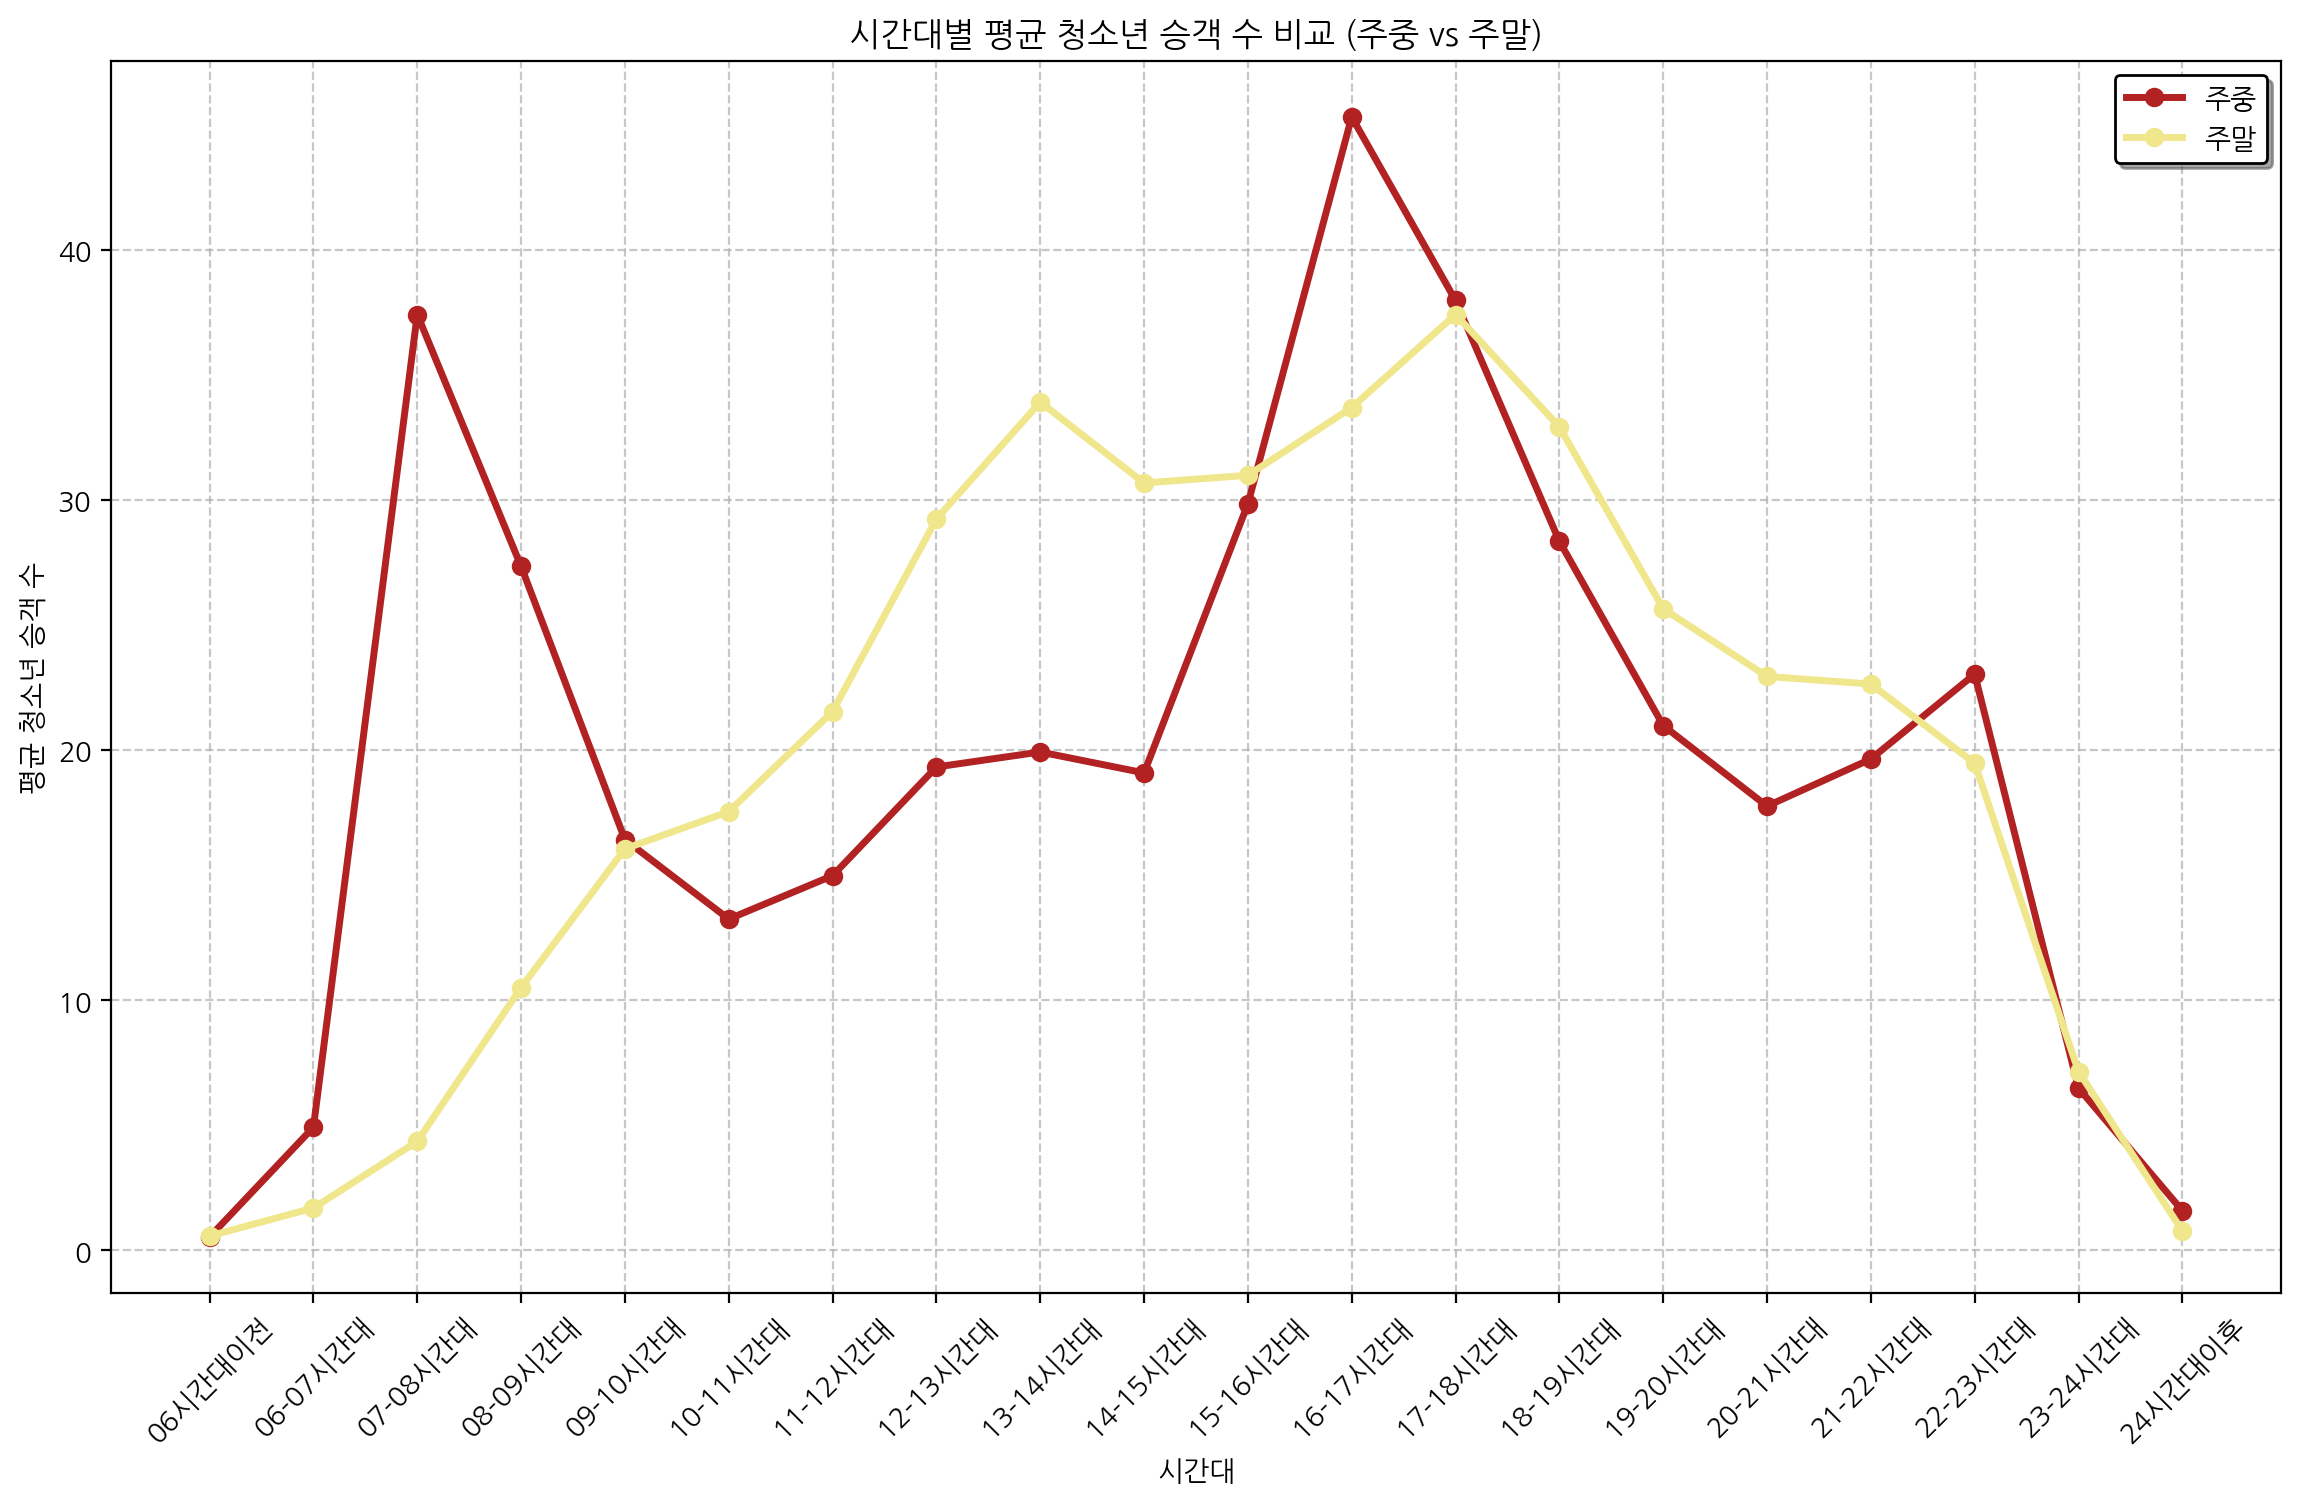

In [228]:
# 그래프 그리기 (주중 vs 주말 비교)
plt.figure(figsize=(14, 8))
plt.plot(mean_weekday.index, mean_weekday.values, label='주중', marker='o', color='firebrick', linewidth=2.5)
plt.plot(mean_weekend.index, mean_weekend.values, label='주말', marker='o', color='khaki', linewidth=2.5)
plt.xlabel('시간대')
plt.ylabel('평균 청소년 승객 수')
plt.title('시간대별 평균 청소년 승객 수 비교 (주중 vs 주말)')
plt.legend(frameon=True, shadow=True, facecolor='white', edgecolor='black')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### 분석 결과


## 3. 청소년 거주 지역

In [176]:
import geopandas as gpd

In [177]:
# 주민등록 인구 데이터 불러오기
df_pop = pd.read_csv('거주인구.csv', skiprows = 2)
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   행정기관코드  25 non-null     int64 
 1   행정기관    25 non-null     object
 2   전체      25 non-null     object
 3   남자      25 non-null     object
 4   여자      25 non-null     object
 5   아동전체    25 non-null     object
 6   아동남자    25 non-null     object
 7   아동여자    25 non-null     object
 8   청소년 전체  25 non-null     object
 9   청소년남자   25 non-null     object
 10  청소년여자   25 non-null     object
 11  청년전체    25 non-null     object
 12  청년남자    25 non-null     object
 13  청년여자    25 non-null     object
dtypes: int64(1), object(13)
memory usage: 2.9+ KB


In [178]:
# 필요한 컬럼만 선택
columns_needed = ['행정기관코드', '행정기관', '청소년 전체', '청소년남자', '청소년여자']
data = df_pop[columns_needed].copy()

# 데이터 타입 변환
data['청소년 전체'] = data['청소년 전체'].str.replace(',', '').astype(int)
data['청소년남자'] = data['청소년남자'].str.replace(',', '').astype(int)
data['청소년여자'] = data['청소년여자'].str.replace(',', '').astype(int)

# 데이터 확인
data.head()

,행정기관코드,행정기관,청소년 전체,청소년남자,청소년여자
0,1111000000,서울특별시 서울특별시 종로구,19718,9296,10422
1,1114000000,서울특별시 서울특별시 중구,13415,6412,7003
2,1117000000,서울특별시 서울특별시 용산구,26090,12518,13572
3,1120000000,서울특별시 서울특별시 성동구,36886,17919,18967
4,1121500000,서울특별시 서울특별시 광진구,48615,23419,25196


In [179]:
# 청소년 인구 통계 계산
max_youth_population_area = data.loc[data['청소년 전체'].idxmax()]['행정기관']
min_youth_population_area = data.loc[data['청소년 전체'].idxmin()]['행정기관']

print("가장 많은 청소년 인구:", max_youth_population_area)
print("가장 적은 청소년 인구:", min_youth_population_area)

가장 많은 청소년 인구: 서울특별시 서울특별시 강남구 
가장 적은 청소년 인구: 서울특별시 서울특별시 중구 


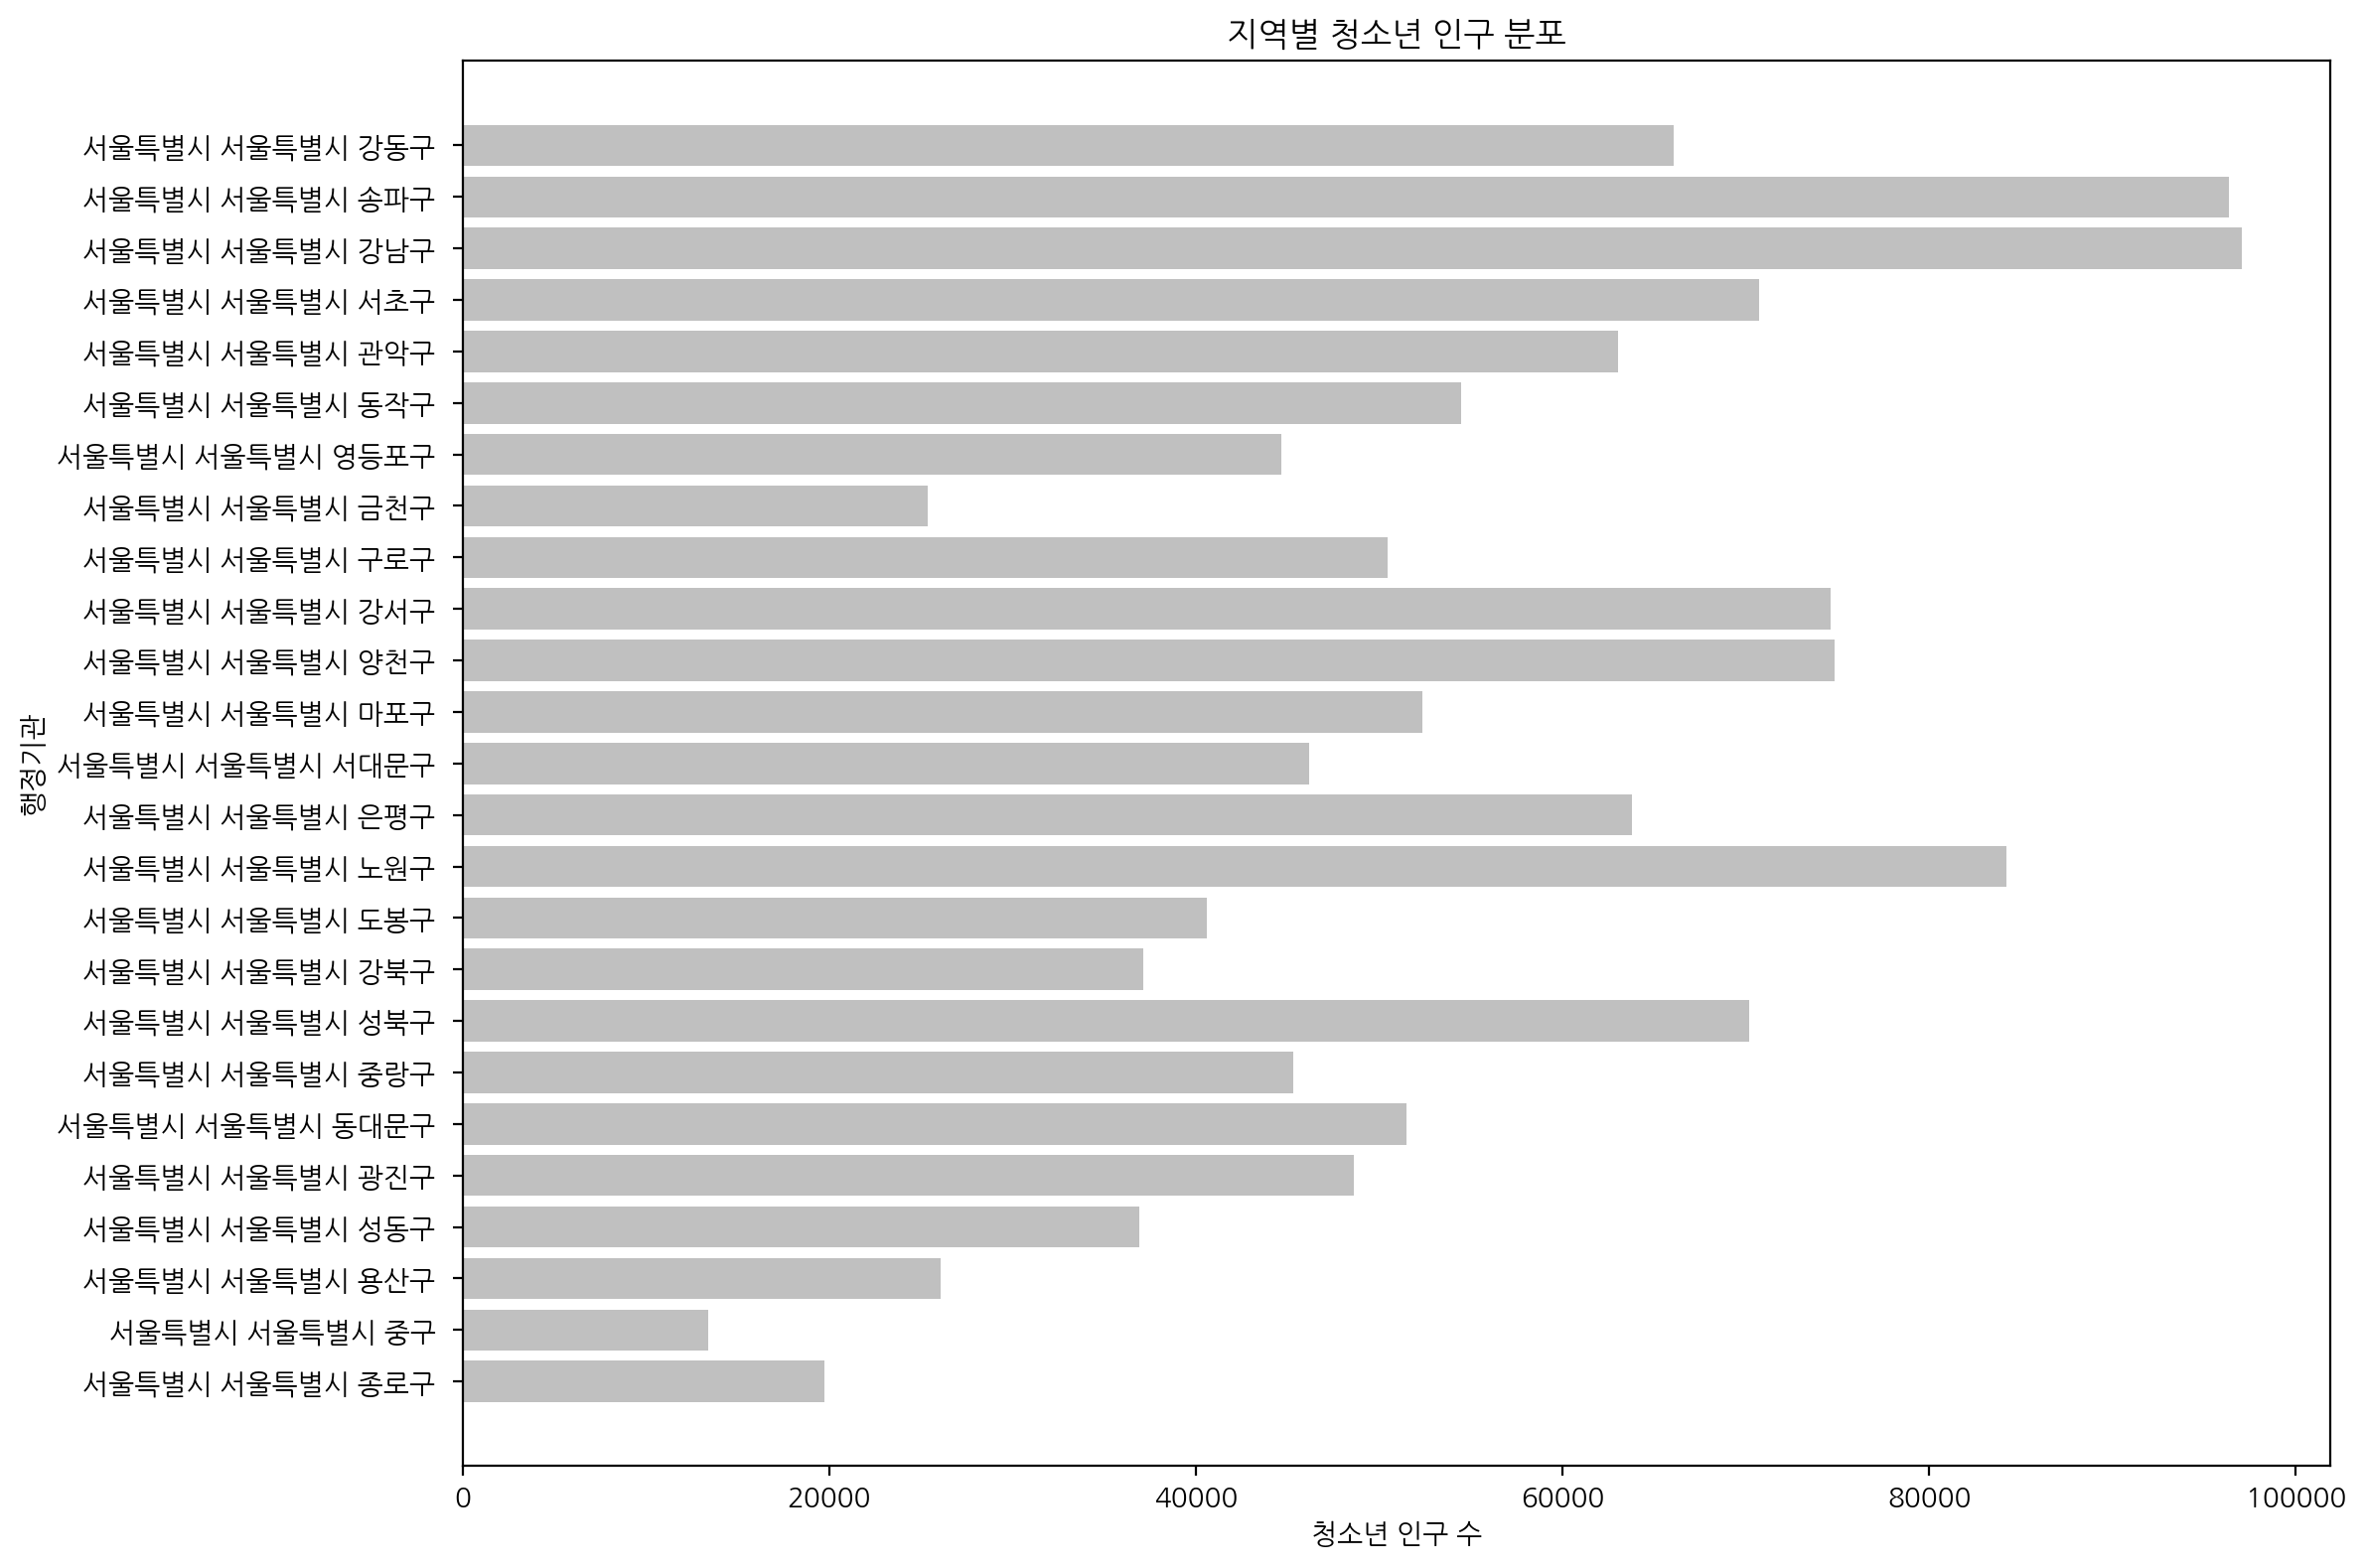

In [180]:
# 지역별 청소년 인구 분포
plt.figure(figsize=(12, 8))
plt.barh(data['행정기관'], data['청소년 전체'], color='silver')
plt.xlabel('청소년 인구 수')
plt.ylabel('행정기관')
plt.title('지역별 청소년 인구 분포')
plt.tight_layout()
plt.show()

In [181]:
# 서울 행정구역 GeoJSON 파일 불러오기
gdf_seoul = gpd.read_file('SIG_Seoul.geojson')

In [182]:
# "청소년 전체" 열의 데이터를 숫자형으로 변환
df_pop['청소년 전체'] = df_pop['청소년 전체'].str.replace(',', '').astype(int)

# '행정기관코드' 열의 데이터를 문자열로 변환하고 슬라이싱
df_pop['행정기관코드'] = df_pop['행정기관코드'].astype(str).str[:5]

In [183]:
# GeoDataFrame과 인구 데이터를 병합
gdf_seoul = gdf_seoul.merge(df_pop, how='left', left_on='SIG_CD', right_on='행정기관코드')

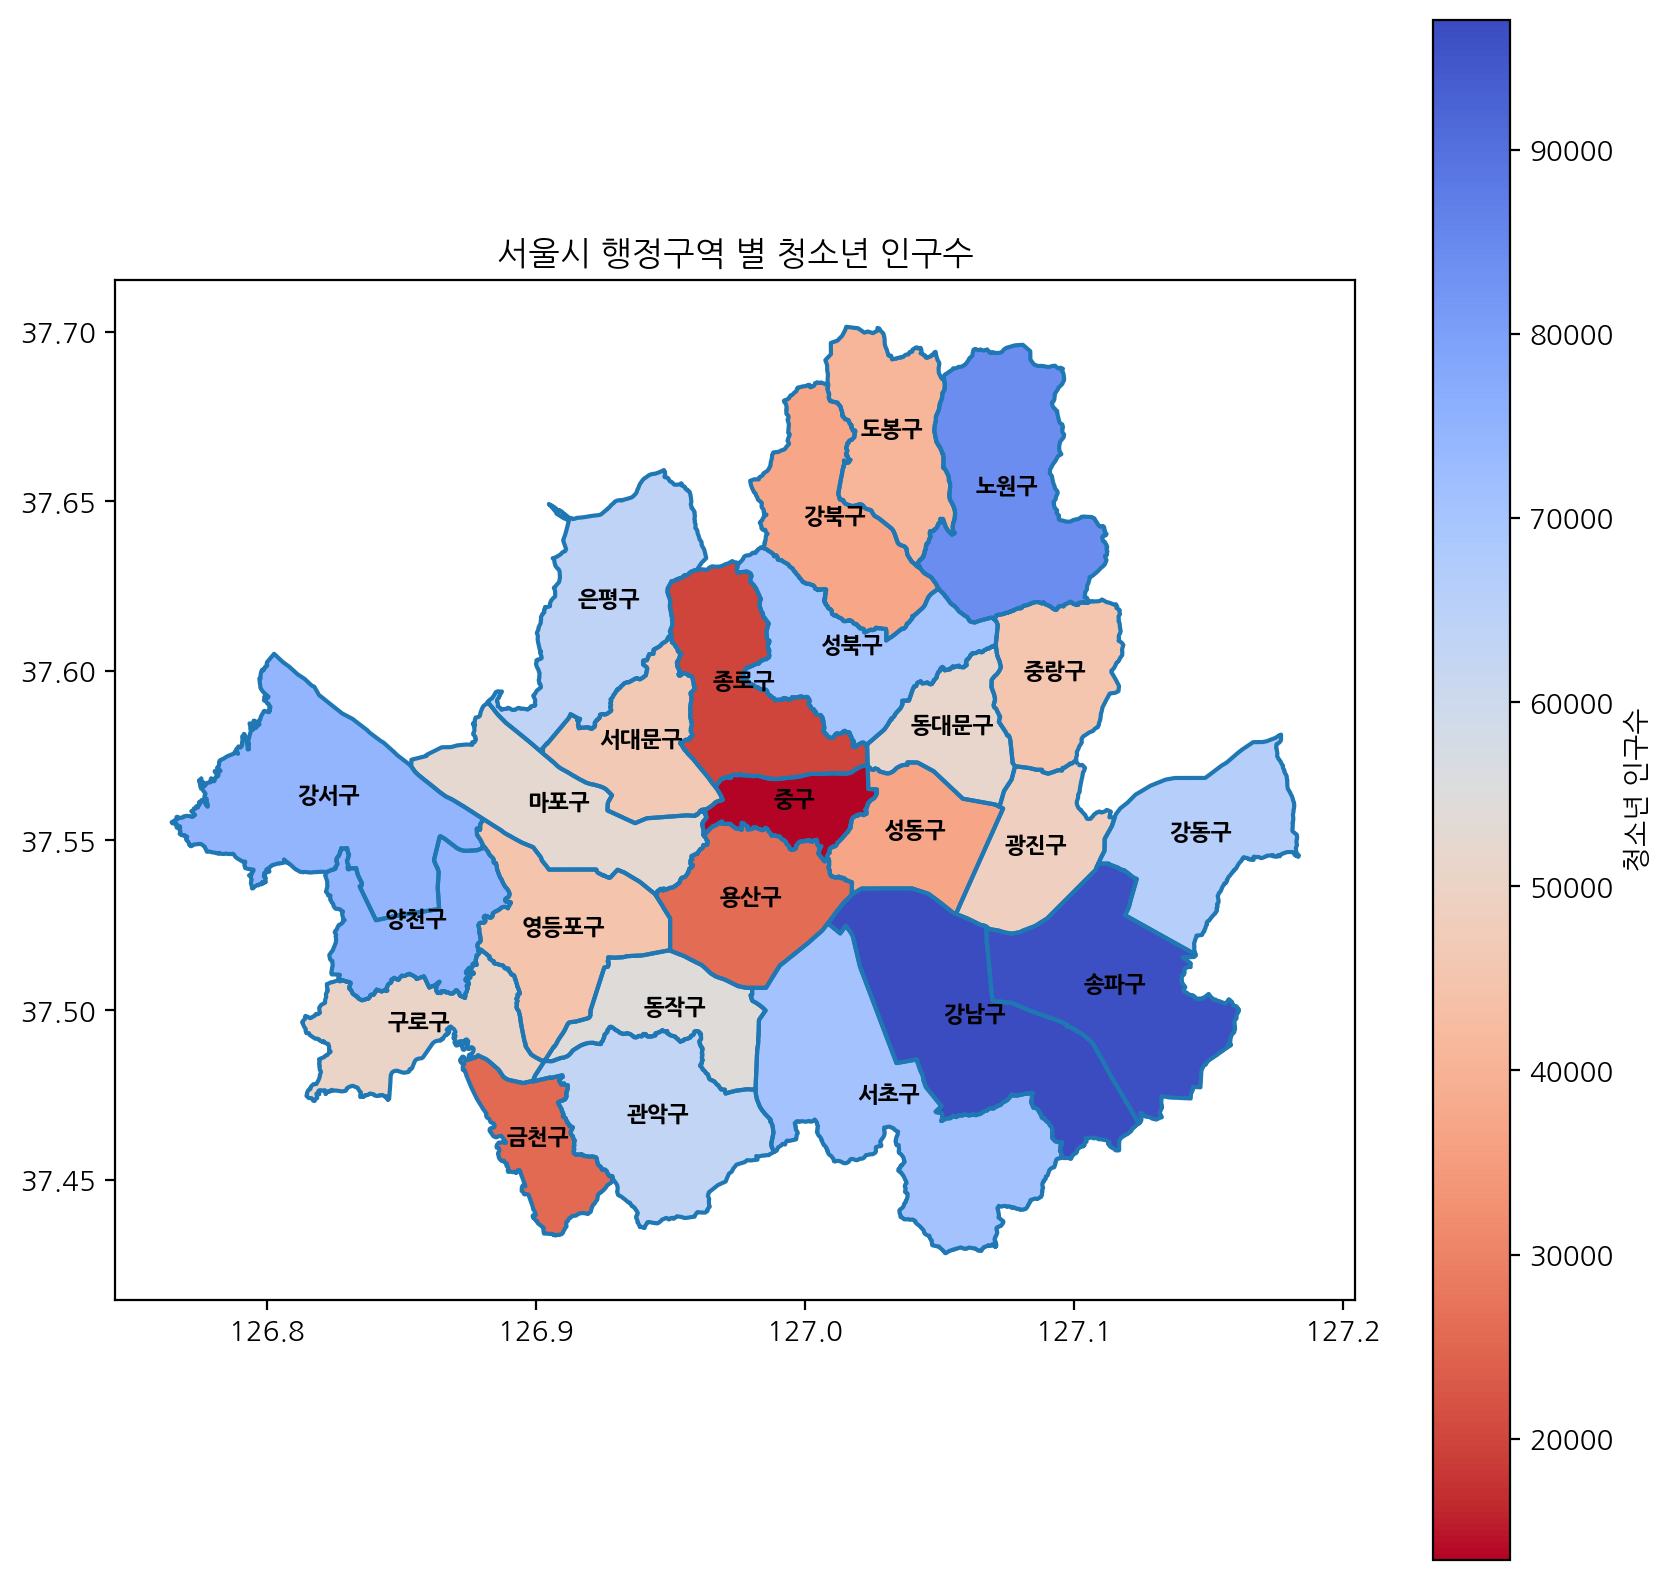

In [184]:
# 지도 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_seoul.boundary.plot(ax=ax)
gdf_seoul.plot(column='청소년 전체', ax=ax, legend=True, cmap='coolwarm_r', legend_kwds={'label': "청소년 인구수"})
plt.title("서울시 행정구역 별 청소년 인구수")

# 지역 이름 추가
for idx, row in gdf_seoul.iterrows():
    plt.annotate(text=row['SIG_KOR_NM'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center', fontsize=8, color='black', weight='bold')

plt.show()

In [185]:
# 청소년 인구 성비 불균형 분석
data['성비'] = data['청소년남자'] / data['청소년여자']

# 성비 불균형이 큰 지역 확인
top_imbalanced_areas = data.sort_values(by='성비', ascending=False).head(5)
bottom_imbalanced_areas = data.sort_values(by='성비').head(5)

top_imbalanced_areas, bottom_imbalanced_areas

(        행정기관코드              행정기관  청소년 전체  청소년남자  청소년여자        성비
 24  1174000000  서울특별시 서울특별시 강동구    66070  34094  31976  1.066237
 14  1147000000  서울특별시 서울특별시 양천구    74817  38549  36268  1.062893
 10  1135000000  서울특별시 서울특별시 노원구    84202  43100  41102  1.048611
 22  1168000000  서울특별시 서울특별시 강남구    97040  49560  47480  1.043808
 9   1132000000  서울특별시 서울특별시 도봉구    40601  20512  20089  1.021056,
         행정기관코드               행정기관  청소년 전체  청소년남자  청소년여자        성비
 12  1141000000  서울특별시 서울특별시 서대문구    46154  21628  24526  0.881840
 0   1111000000   서울특별시 서울특별시 종로구    19718   9296  10422  0.891959
 13  1144000000   서울특별시 서울특별시 마포구    52345  24683  27662  0.892307
 20  1162000000   서울특별시 서울특별시 관악구    63038  29914  33124  0.903091
 5   1123000000  서울특별시 서울특별시 동대문구    51503  24463  27040  0.904697)

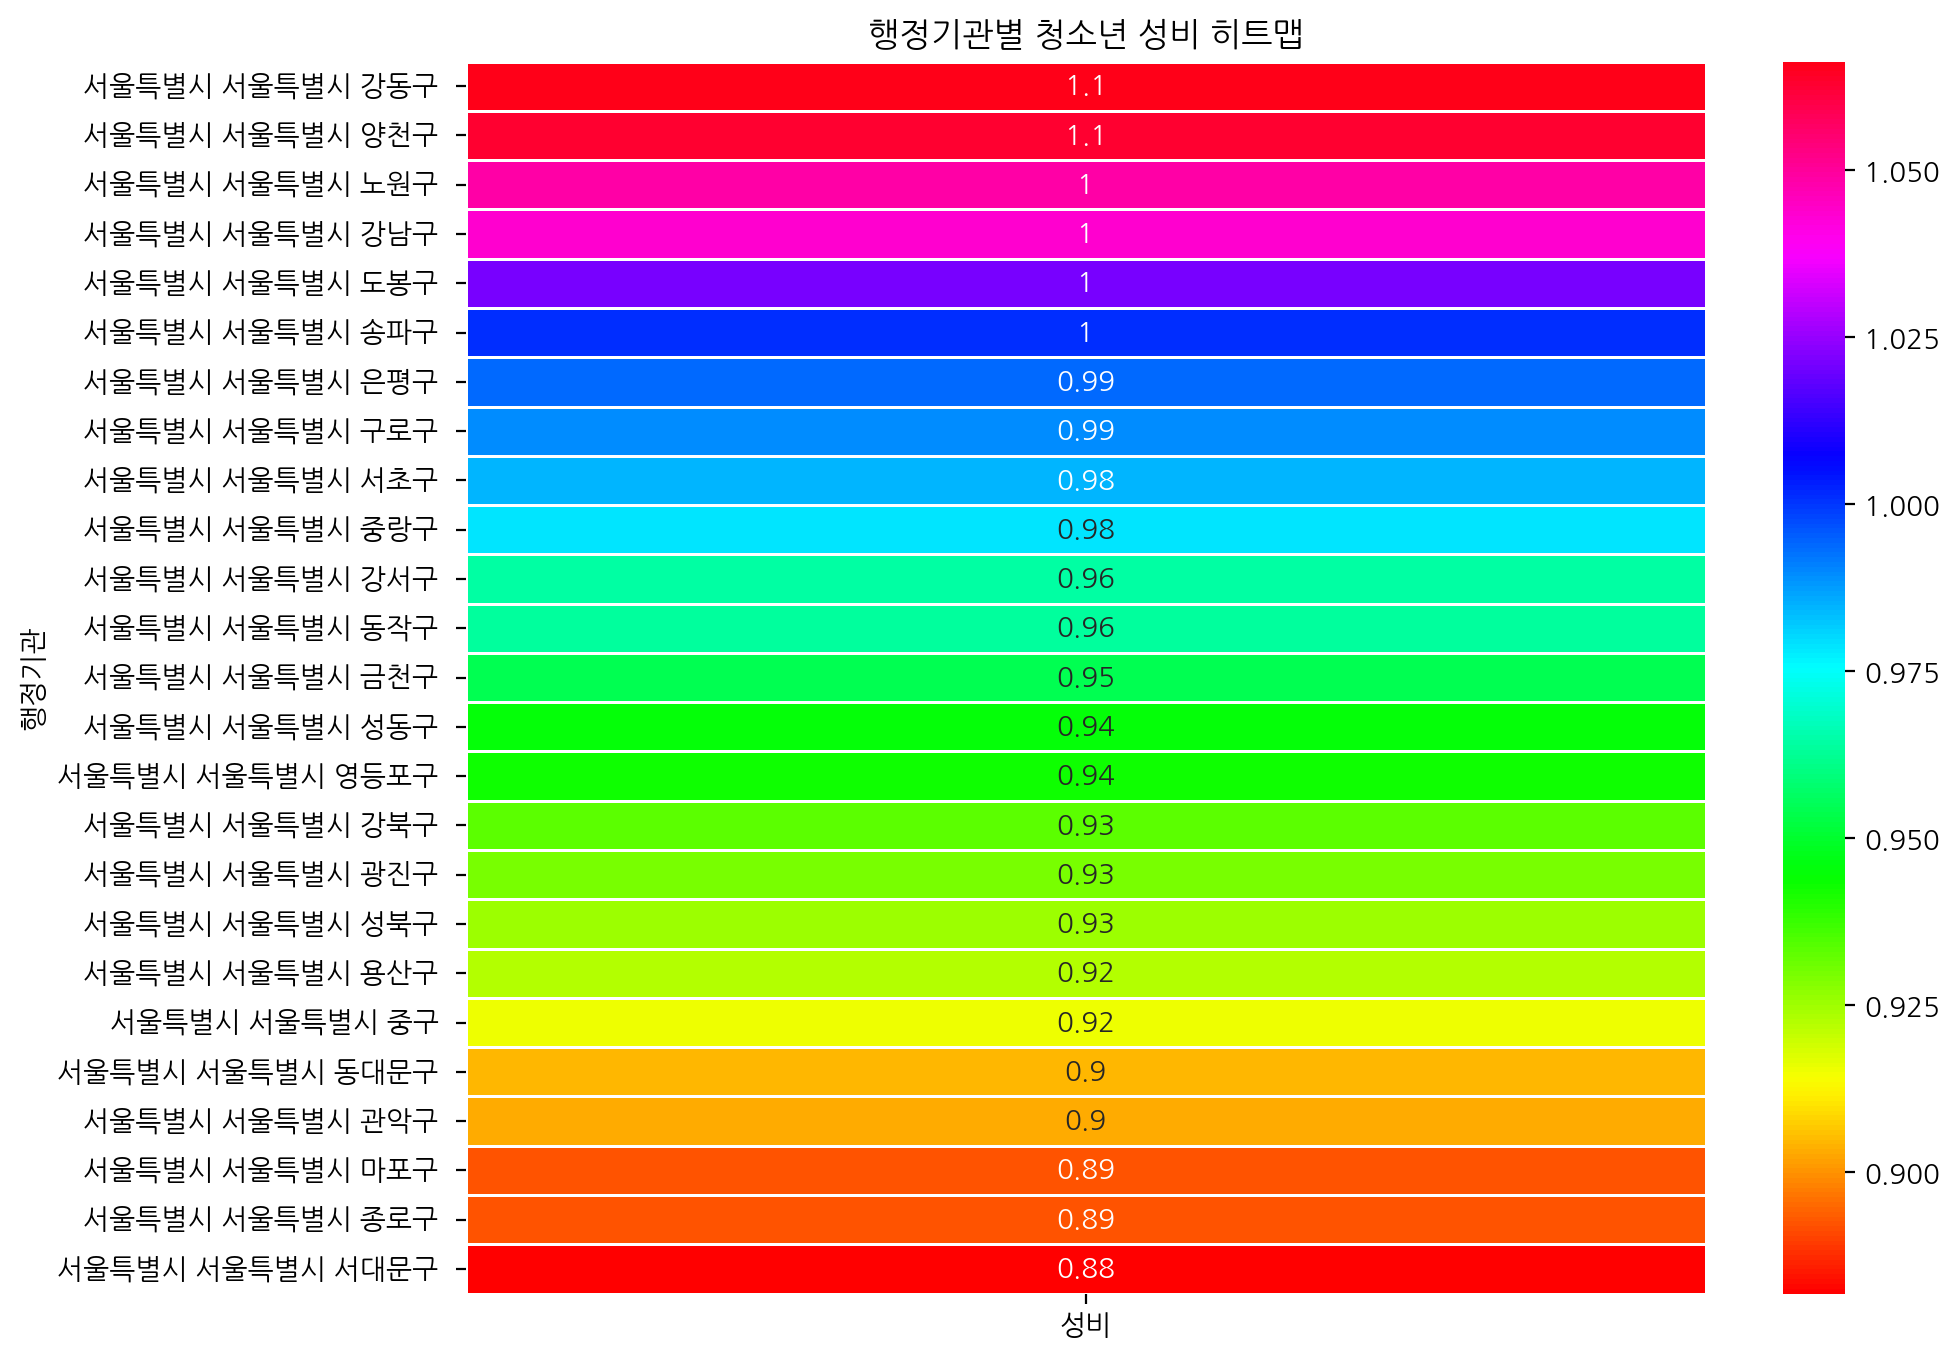

In [186]:
# 히트맵을 그리기 위해 데이터 준비
heatmap_data = data[['행정기관', '성비']].copy()
heatmap_data.set_index('행정기관', inplace=True)
heatmap_data = heatmap_data.sort_values(by='성비', ascending=False)

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='hsv', cbar=True, linewidths=.5)
plt.title('행정기관별 청소년 성비 히트맵')
plt.show()